# Projekt Eksploracji Danych Youtube Trending - Checkpoint 3
### Ocena ważności atrybutów i ich ewentualna redukcja

### Maria Naklicka    
127313 ISWD

### Norbert Schlaffke 
127201 ISWD

## Podsumowanie wszystkich atrybutów:
 * **Atrybuty ilościowe**
     
     * `views` - liczba wyświetleń - `Int` **zmienna w czasie**
     * `likes` - liczba pozytywnych reakcji - `Int` **zmienna w czasie**
     * `dislikes` - liczba negatywnych reakcji - `Int` **zmienna w czasie**
     * `comment_count` - liczba komentarzy - `Int` - **zmienna w czasie**
     * `title_num_words` - z ilu słów składa się tytuł (wykluczamy liczby) - `Int`
     * `title_capital` - procentowa zawartość wielkich liter - `Float <0, 1>`
     * `title_exc_count` - liczba wykrzykników - `Int`
     * `title_que_count` - liczba znaków zapytania - `Int`
     * `tags_count` - liczba tagów - `Int`
     * `uses_previous_tags` - jaki odsetek spośród użytych tagów pojawił się w filmach trendujących w ciągu 30 dni (wstecz) od publikacji danego filmu - `Float <0,1>`  
     * `desc_lines_count` - długość opisu w liniach - `Int`
     * `desc_num_words` - długośc opisu w słowach - `Int`
     * `links_count` - liczba linków w opisie - `Int`
     * `fb_links` - liczba linków do Facebooka - `Int`
     * `ig_links` - liczba linków do Instagrama - `Int`
     * `tt_links` - liczba linków do Twittera - `Int`
     * `sc_links` - liczba linków do SnapChata - `Int`
     * `social_links` - suma Fb, Ig, Tt, Sc - `Int`
     * `publish_hour_sin` - sinus atrybutu cyklicznego dla godziny publikacji - `Float`
     * `publish_hour_cos` - cosinus atrybutu cyklicznego dla godziny publikacji - `Float`
     * `publish_day_sin` - sinus atrybutu cyklicznego dla dnia publikacji - `Float`
     * `publish_day_cos` - cosinus atrybutu cyklicznego dla dnia publikacji - `Float`
     * `publish_month_sin` - sinus atrybutu cyklicznego dla miesiąca publikacji - `Float`
     * `publish_day_cos` - cosinus atrybutu cyklicznego dla miesiąca publikacji - `Float`
     * `days_to_viral` - liczba dni od daty publikacji do daty trending - `Int`
     * `brightness` - Średnia jasność miniatury - `Float <0, 255>`
 * **Atrybuty jakościowe**
     * `category_id` - identyfikator kategorii - `Int`
     * `comments_disabled` - komentowanie wyłączone - `Boolean`
     * `rating_disabled` - ocenianie wyłączone - `Boolean`
     * `video_error_or_removed` - błąd video lub usunięte - `Boolean`
     
 
 * **Reprezentacje**
     * `tf_idf_vector` - reprezentacja opisu za pomocą tf-idf - `Wektor Float`
     * `elmo` - reprezentacja opisu za pomocą ELMo - `Wektor wag Float`
     * `resnet18` - reprezentacja obrazu za pomocą ResNet - `Macierz wag Float`
     * `hog_vec` - reprezentacja obrazu za pomocą HOG - `Macierz wag Float`
     * `objects` - reprezentacja obiektów na obrazie - `Wektor Int o długości 37`
     * `dominant_color` - kolor dominujący na obrazie - `Wektor Int <0, 255> o długości 3`
     * `palette` - paleta barw na obrazie - `Macierz 6x3 Int <0, 255>`

In [0]:
FILE_NAME = 'data_c12.hdf'

In [223]:
!pip install --upgrade tables # To solve error with pd.read_hdf

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [0]:
from google.colab import drive # Google Drive connection
from joblib import Memory # Memmory cache

import pandas as pd
# progress_apply
from tqdm.auto import tqdm  
tqdm.pandas()

from os import path # joinging path
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.style as style 
import seaborn as sns

# For progress bar
from IPython.display import HTML, display
import time

# For ELMO
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow_hub as hub

# To convert datetime.date to seconds
from datetime import datetime, date
import calendar

# GloVe
import gensim.downloader as api

from sklearn.feature_selection import mutual_info_classif

from os import path

%matplotlib inline
# sets the size of the charts
style.use('seaborn-poster') 
style.use('ggplot')

# Helpers

Progress bar

In [0]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## Google Drive


In [226]:
# Mount google drive and load data
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/"
data_path = path.join(drive_path , 'datasets/youtube_data')
image_path = path.join(data_path, 'images')
cache_path = path.join(drive_path, 'cache')

# Set cache
memory = Memory(location=cache_path, verbose=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
file_path = path.join(data_path, FILE_NAME)
df = pd.read_hdf(file_path)

#EDA for categories


It is worth to analize attributes distribution with respect to video categories.


In [0]:
df_all = df.drop_duplicates(subset='video_id', keep='last')
df_cat = df_all[~df_all.category_id.isnull()]
df_cat = df_cat.astype({'category_id': 'int32'})

In [229]:
print("Number of categories: ", len(df_cat.category_id.unique()))
print("Number of films with filled category:", len(df_cat), ", percent: ", 100*round(len(df_cat)/len(df),4),  "%")

Number of categories:  16
Number of films with filled category: 448 , percent:  5.21 %


## General overview

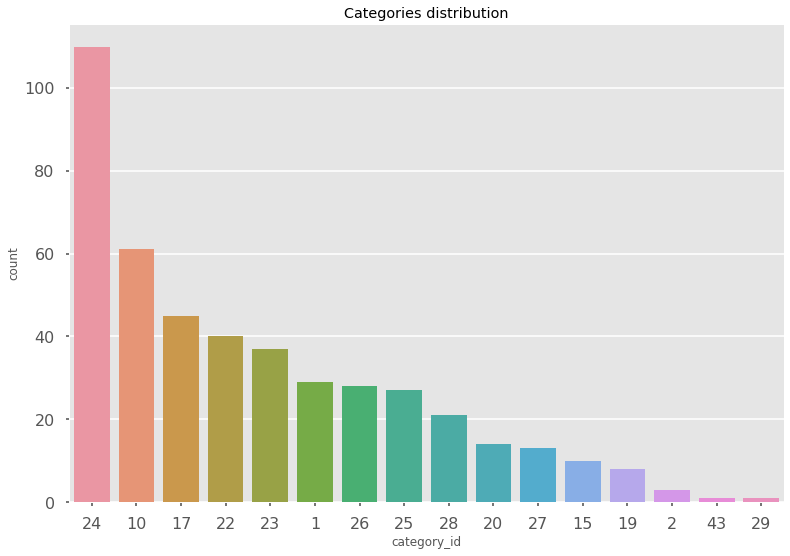

In [230]:
sns.countplot(df_cat.category_id, order=df_cat.category_id.value_counts().index).set_title('Categories distribution');

Data is strongly inballanced with respect to category.

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
def show_plots(data, col, ids, ticks=False, hist=False, rotate=None):
  fig=plt.figure()
  fig.suptitle('Distribution of attribute ' + col + ' by categories', fontsize=16, y=1.0)
  columns = 4
  rows = 4
  for i, id in enumerate(ids):
    data_cat = data.loc[data.category_id == id]
    fig.add_subplot(rows, columns, i+1)
    if hist:
      data_cat[col].hist()
    else:
      sns.countplot(data_cat[col])
    if not ticks:
      plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
      plt.tick_params(axis='x', labelsize=8)
    if rotate:
      plt.xticks(rotation=rotate)
    plt.tick_params(axis='y', labelsize=12)
    plt.xlabel('')
    plt.title(str(id))
  fig.tight_layout(pad=1.5)
  plt.show()

In [0]:
cats = list(df_cat.category_id.value_counts().keys())

We will analyze distributions of some attributes for categories keeping in mind semi-supervised learning task.




## publish_month

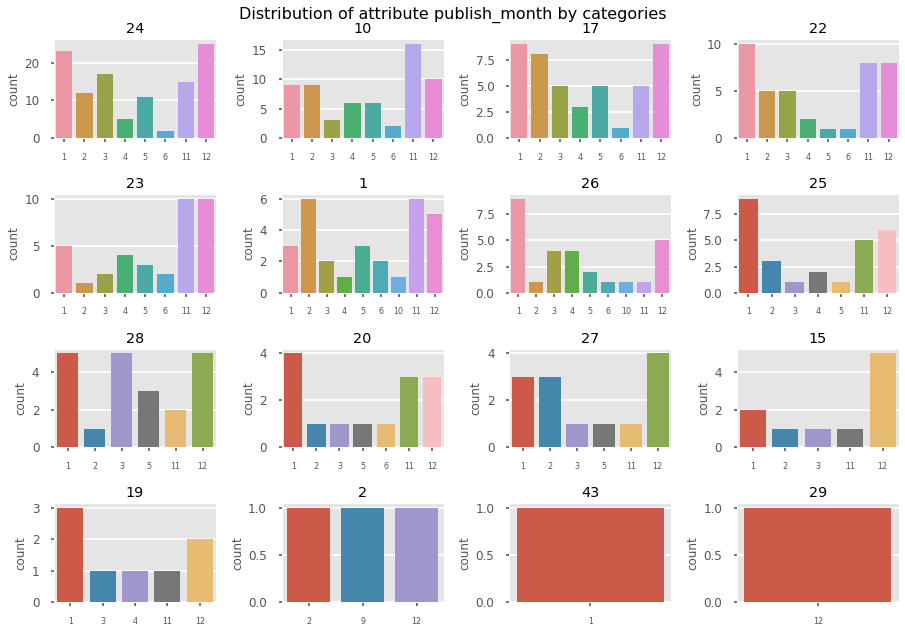

In [234]:
show_plots(df_cat, 'publish_month', cats, ticks=True)

The first, most visible conclusion is quite obvious fact, that along with data amount growth, it's variety also grows. Most categories are quite similar to the global trend when it comes to publish month. Looking further, we can see that there are some differences between categories, so information about publish month could be useful for predicting categories. For example, great majority of films in category 23 was published in late fall and winter months - November, December and January. This category can be related to winter or maybe Christmas. In spite of the fact, that in other categories, a lot of videos comes from November and December, in this category, the dominance is unusually strong. Category number 1 is characteristic because of dominance of February.  The lack of July, August, September and October is not surprising - there were liitle videos from these months in the whole dataset.

## publish_hour

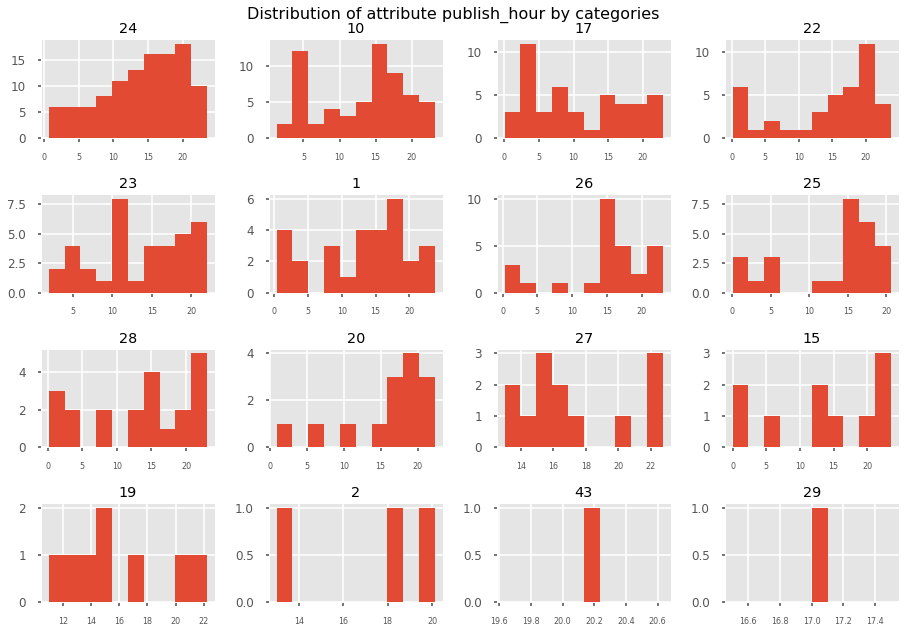

In [235]:
show_plots(df_cat, 'publish_hour', cats, hist=True, ticks=True)

Comparing distributions of publication hours among categories with global distribution, we can observe some intesresting aberrations. The first one is dominance of night hours for category number 17. The second one - the presence of peak around noon hours for category 23. For category 15 the characteristic factor is very little amount of videos published between 15 and 20 o'clock. Hence, we conclude that the time of publication can be an informative premise for the categorization of films.

## publish_day

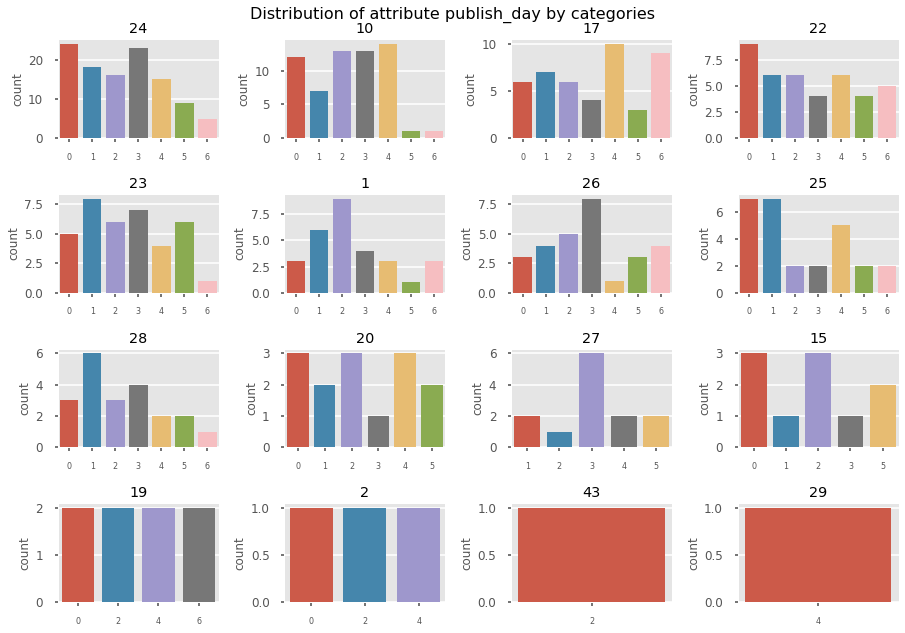

In [236]:
show_plots(df_cat, 'publish_day', cats, ticks=True)

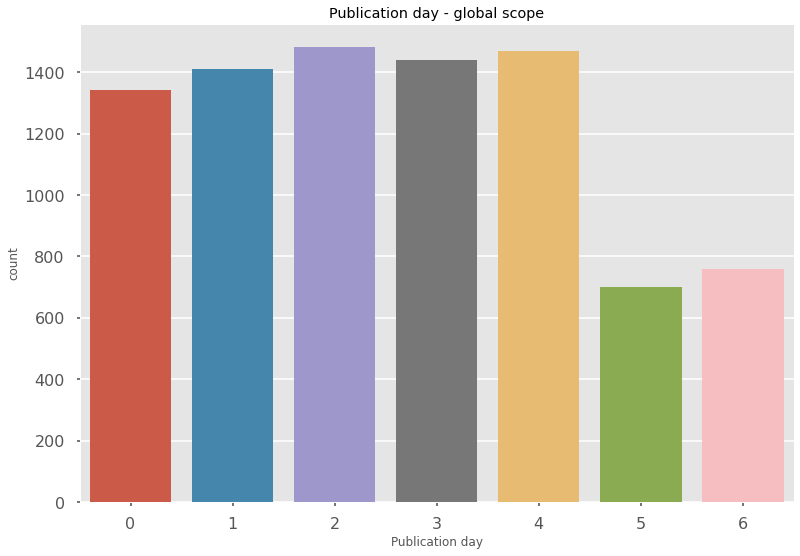

In [237]:
sns.countplot(df_all.publish_day)
plt.xlabel("Publication day");
plt.title('Publication day - global scope');

The publication day also seems to be a good discriminator for the category. It is worth paying attention to category 17, for which films published on Friday and Sunday have the largest share, which is particularly characteristic in the light of the low share of Sunday in the overall trend. Films in category 25 were most often published on Monday, Tuesday and Friday, category 1 on Wednesday and 26 on Thursday.

## time_to_viral

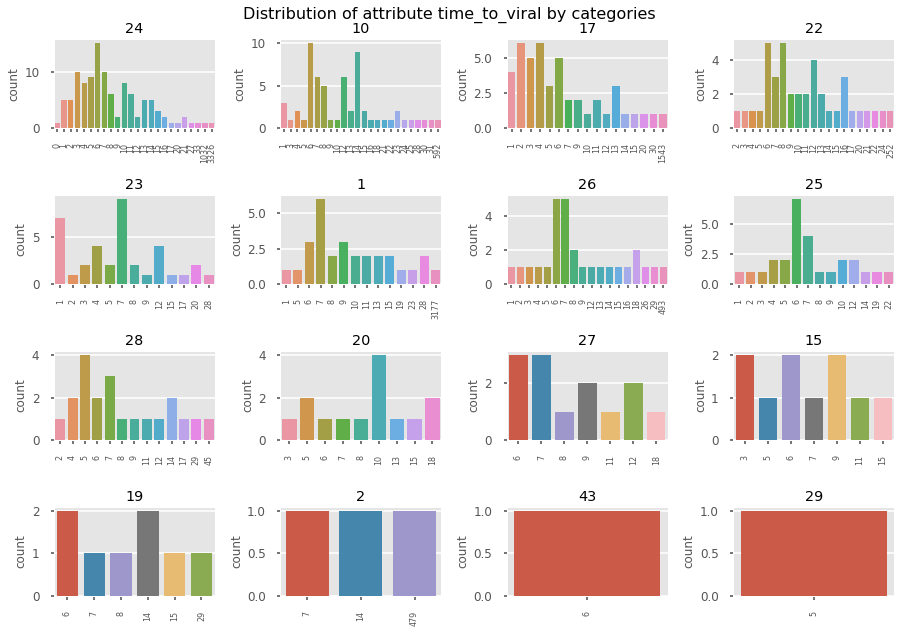

In [238]:
show_plots(df_cat, 'time_to_viral', cats, ticks=True, rotate=90)

## title_num_words

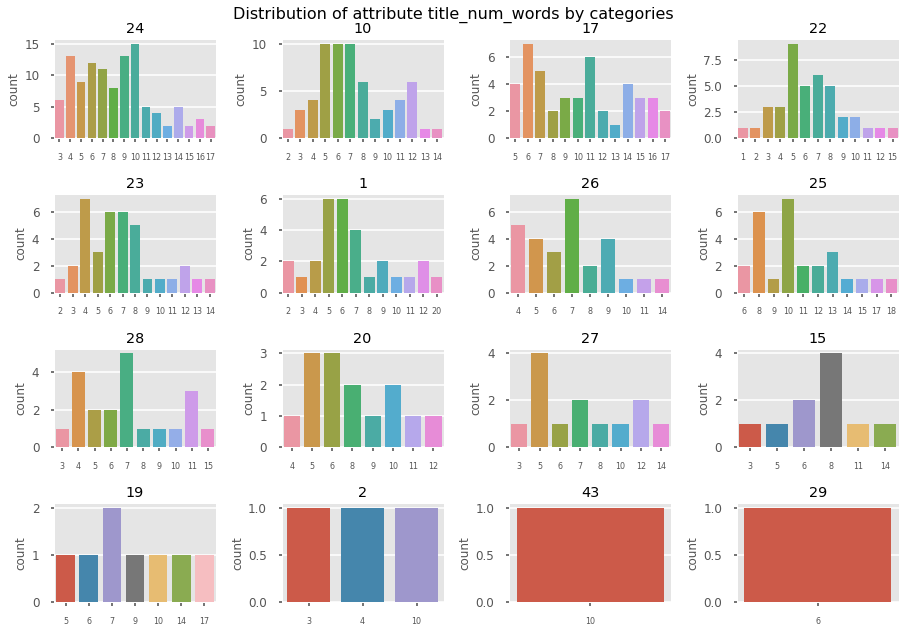

In [239]:
show_plots(df_cat, 'title_num_words', cats, ticks=True)

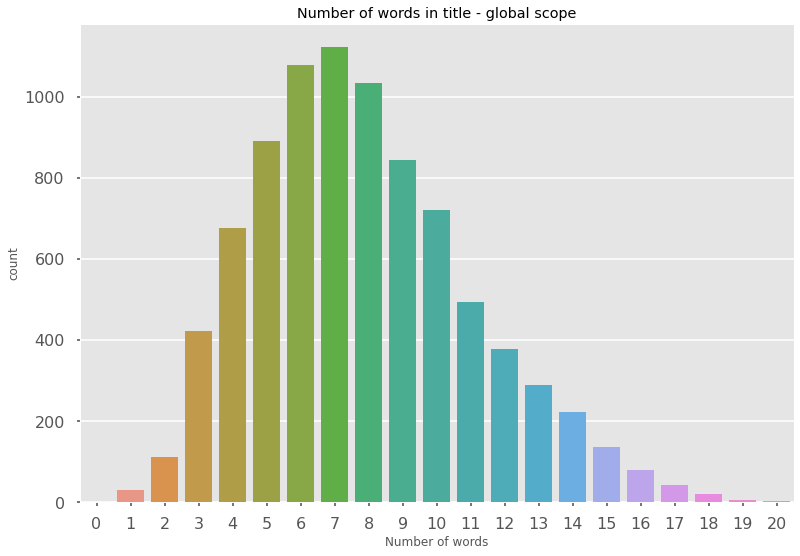

In [240]:
sns.countplot(df_all.title_num_words)
plt.xlabel("Number of words");
plt.title('Number of words in title - global scope');

The most charcteristic category in terms of the length of the movie title is the number 25. Note that movies in this category are from 6 to 18 lengths, and titles between 8 and 10 words are most popular. Perhaps 25 is a category that refers to the topic in need of descriptive, longer titles. Category 26, on the other hand, has relatively short titles - most movies have a length of 4 to 7 words, and only sporadically there are movies with a length exceeding 9.

## views

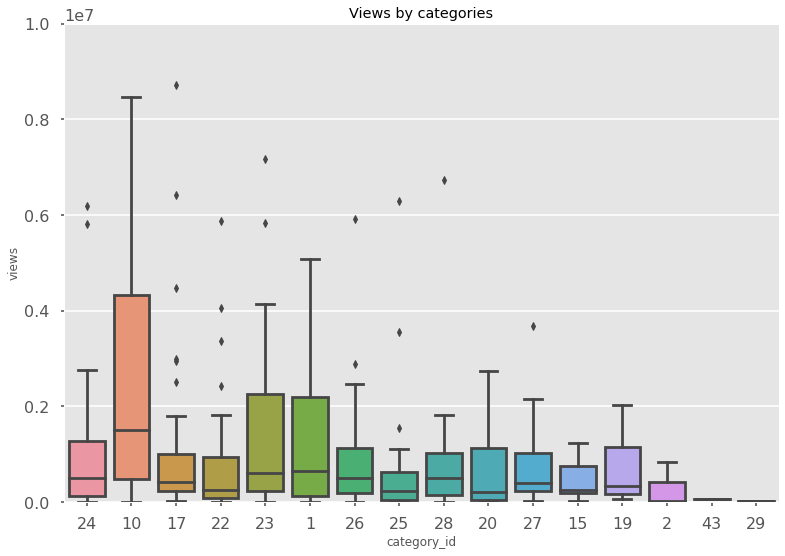

In [241]:
plot = sns.boxplot(x=df_cat['category_id'], y=df_cat['views'], order=cats);
axes = plot.axes
axes.set_ylim(0,1e7);
plt.title("Views by categories");

The differences in the number of views for different categories are immediately visible. One of the categories is distinguished by a very high number of views. This is probably a category related to music. Categories 43 and 29 are very little popular. It may also be related to the fact that they are very poorly represented among the data with the completed category and perhaps in the entire data set.

## likes

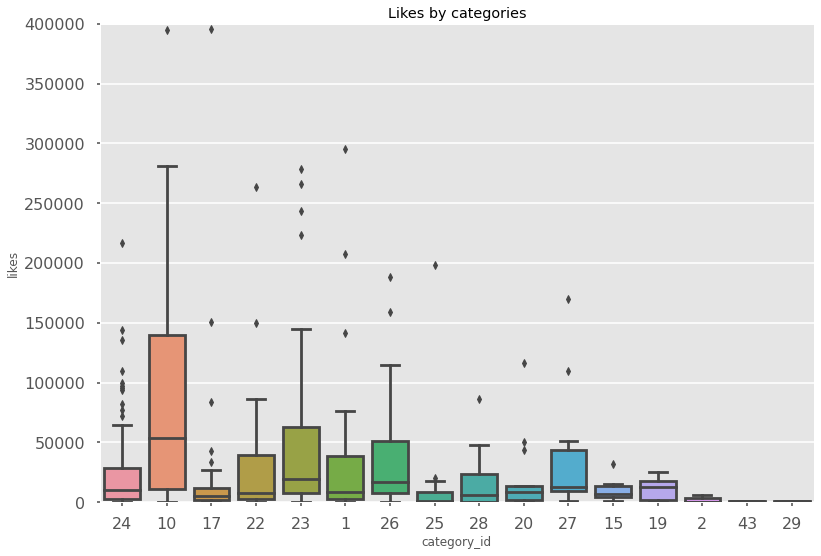

In [242]:
plot = sns.boxplot(x=df_cat['category_id'], y=df_cat['likes'], order=cats);
axes = plot.axes
axes.set_ylim(0,4e5);
plt.title("Likes by categories");

Note the relationship between the number of views and the number of likes. For example: category 10 is the most popular and also receives the most positive reactions - this is not surprising, while category 1, which ranks together with category 23 in second place among popular categories, has relatively fewer likes than category 23 which is more likable. Also movies in category 22 seem more liked than in category 17.

## dislikes

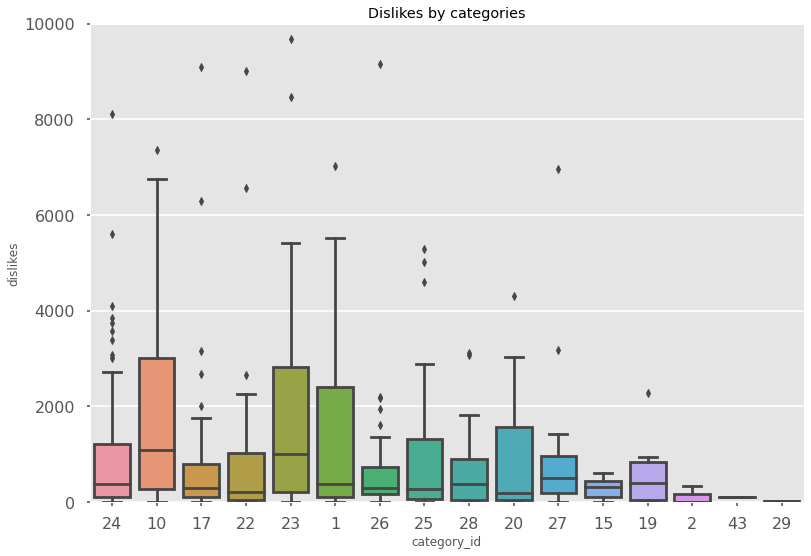

In [243]:
plot = sns.boxplot(x=df_cat['category_id'], y=df_cat['dislikes'], order=cats);
axes = plot.axes
axes.set_ylim(0,1e4);
plt.title("Dislikes by categories");

In the case of negative reactions, one can also notice a relative disproportion for categories 23 and 1. Probably films in category 23 arouse more emotions than in category 1. Perhaps it is related to politics.

All **views, likes, dislikes and comments** seem to be somehow correlated

## comment_count

Text(0.5, 1.0, 'comment_count by categories')

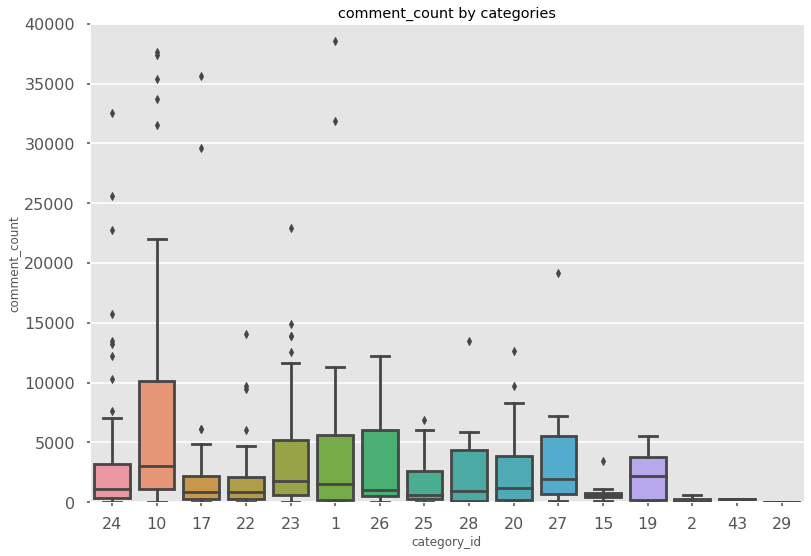

In [244]:
plot = sns.boxplot(x=df_cat['category_id'], y=df_cat['comment_count'], order=cats);
axes = plot.axes
axes.set_ylim(0,4e4);
axes.set_title('comment_count by categories')

The distribution of the number of comments between categories is similar to the distribution of the number of views.

## links_count

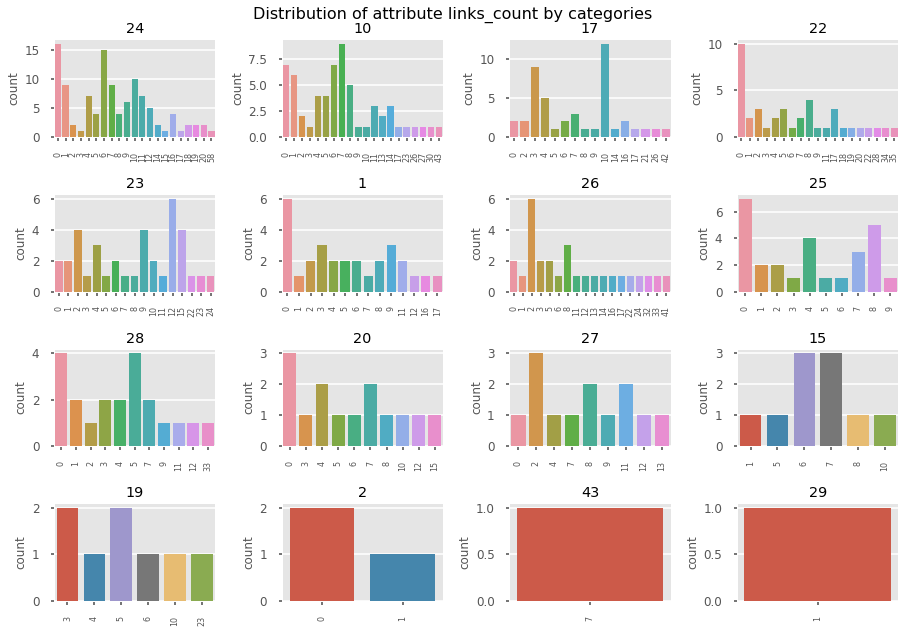

In [245]:
show_plots(df_cat, 'links_count', cats, ticks=True, rotate=90)

The categories are very diverse in terms of the number of links in the description. Films in category 25 have few links, up to a maximum of 9, while those in category 17 rarely have no links, and their number reaches even 42.





## social_links

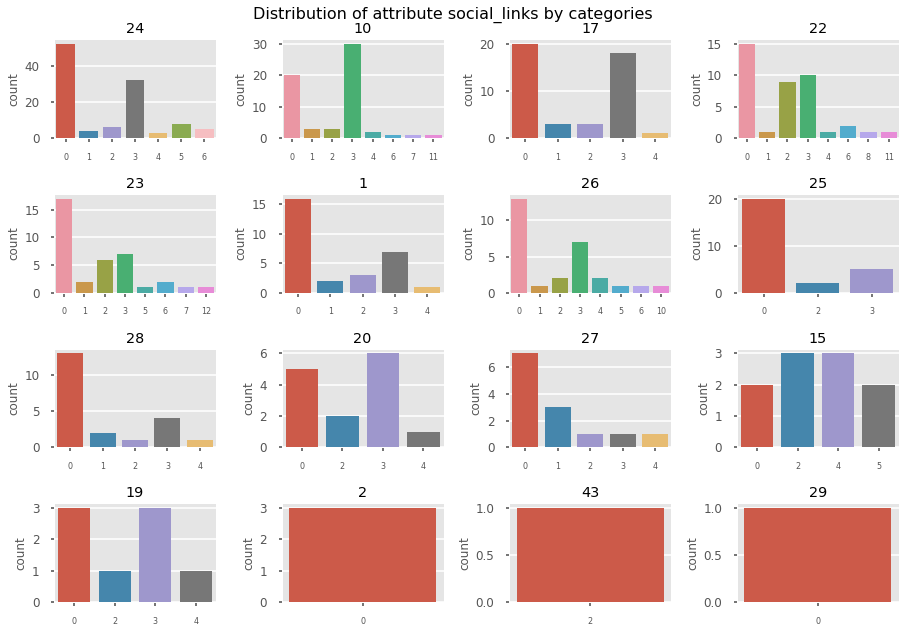

In [246]:
show_plots(df_cat, 'social_links', cats, ticks=True)

Links to social networks are present in some categories more often than in others - for example, for category 25, the presence of links is very little popular, and if they are already, then a maximum of 3. However, movies in category 10 usually have 3 links. It is worth paying attention to the number 3 - almost all charts have a noticeable peak for 3 links. These are probably links to the creator's account on three of the most popular social networking sites: Facebook, Instagram and Twitter.

## fb_links

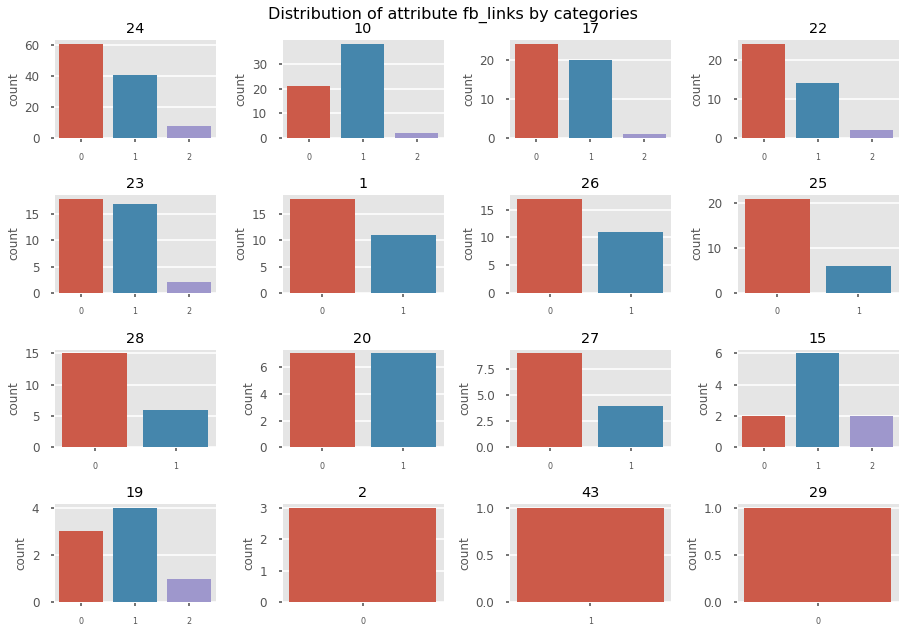

In [247]:
show_plots(df_cat, 'fb_links', cats, ticks=True)

## tt_links

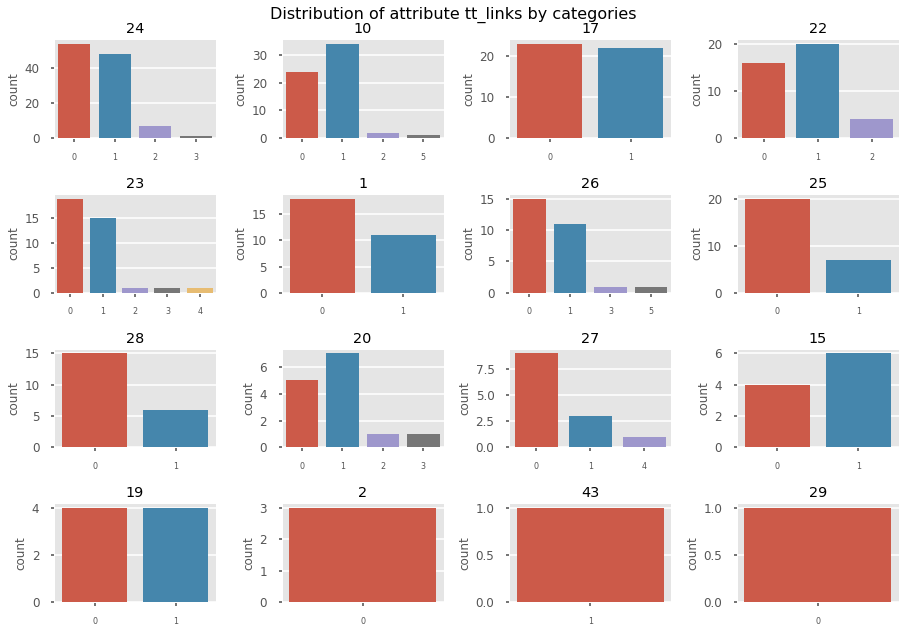

In [248]:
show_plots(df_cat, 'tt_links', cats, ticks=True)

## ig_links

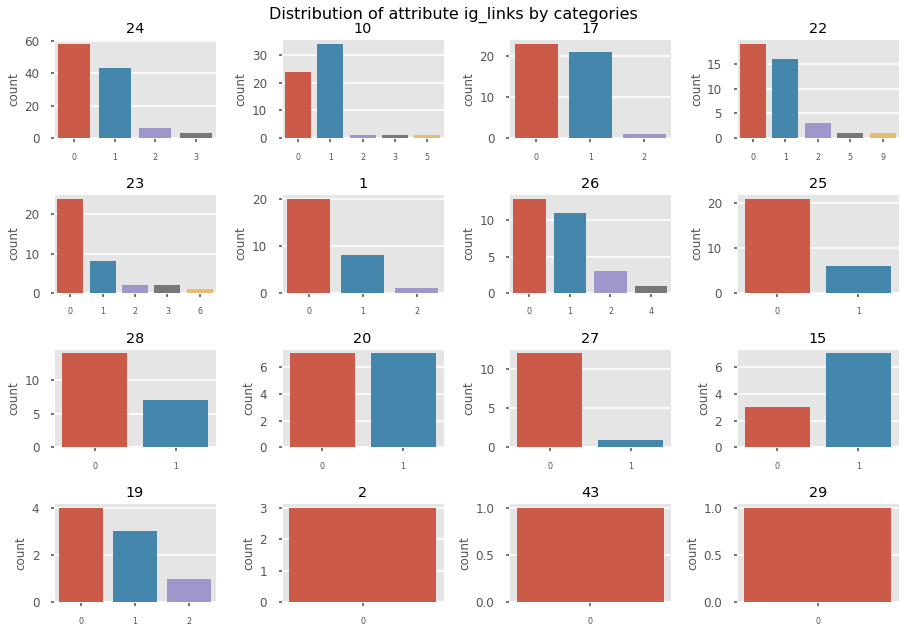

In [249]:
show_plots(df_cat, 'ig_links', cats, ticks=True)

It is worth comparing the distribution of the number of links to individual social networks within the category. In descriptions for category 22, you'll find links to Twitter and Instagram more often than Facebook. It happens that there are several times more Instagram links than links to other websites. For category 10, the distribution of data is similar for all 3 portals.



## Tags

Let's take a look on most popular tags in 4 major categories:

In [0]:
from wordcloud import WordCloud
from collections import Counter

In [0]:
def show_wordcloud(data, cat):
  tag_list = []
  for sublist in  data.tags_split.values:
      if sublist is not None:
        for item in sublist:
          tag_list.append(item)
  tags100 = {a: b for a, b in Counter(tag_list).most_common(100)}
  tags100
  wordcloud = WordCloud(background_color='white',
                        max_words=50, 
                        max_font_size=40,
                        random_state=42).generate_from_frequencies(tags100)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.grid(b=None)
  plt.axis("off")
  plt.title("Most used tags in category" + cat);

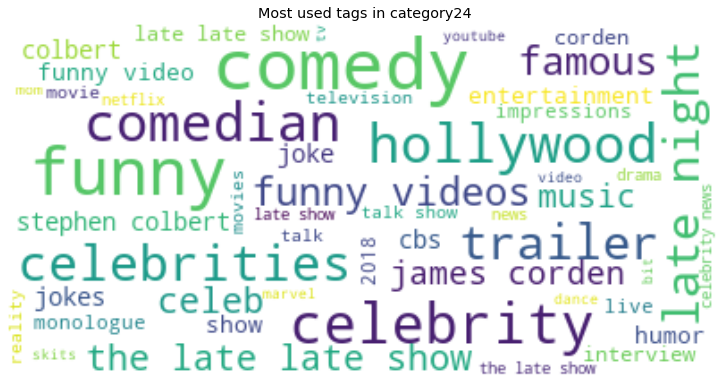

In [252]:
cat_24 = df_cat.loc[df_cat['category_id']==24]
show_wordcloud(cat_24, '24')

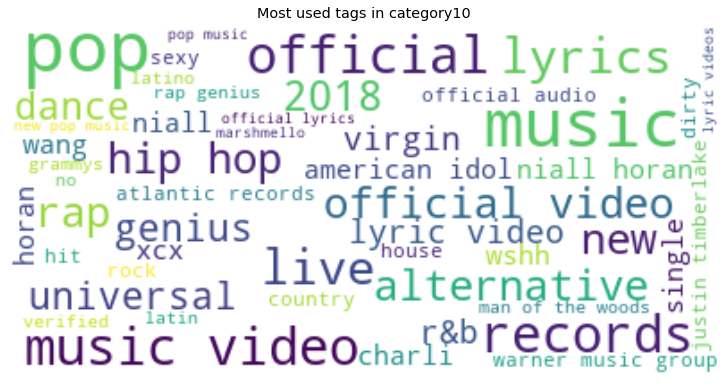

In [253]:
cat_10 = df_cat.loc[df_cat['category_id']==10]
show_wordcloud(cat_10, '10')

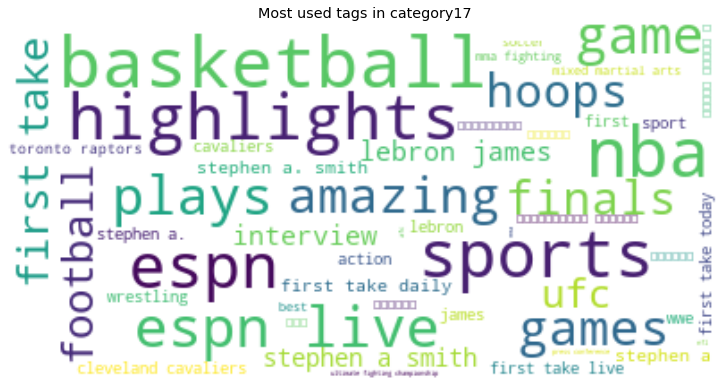

In [254]:
cat_17 = df_cat.loc[df_cat['category_id']==17]
show_wordcloud(cat_17, '17')

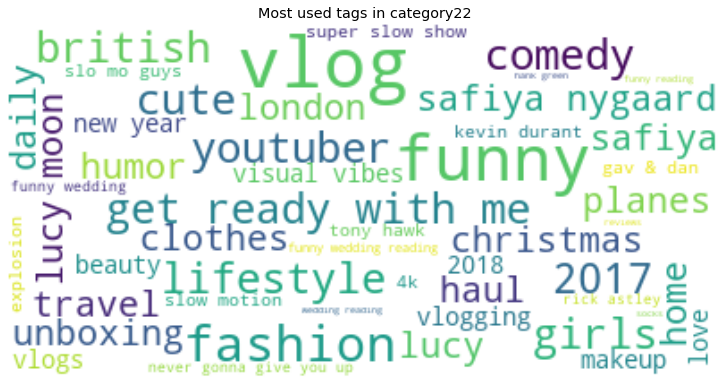

In [255]:
cat_22 = df_cat.loc[df_cat['category_id']==22]
show_wordcloud(cat_22, '22')

As we can see, attributes based on tags can be highly informative - we can guess with high probability the video category from tags .

## desc_num_words

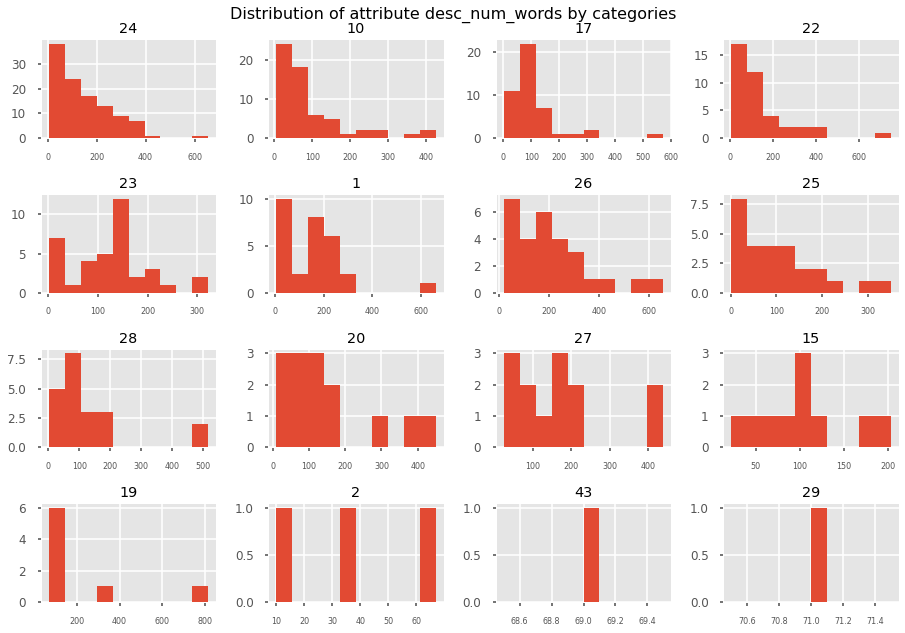

In [256]:
show_plots(df_cat, 'desc_num_words', cats, ticks=True, hist=True)

## brightness

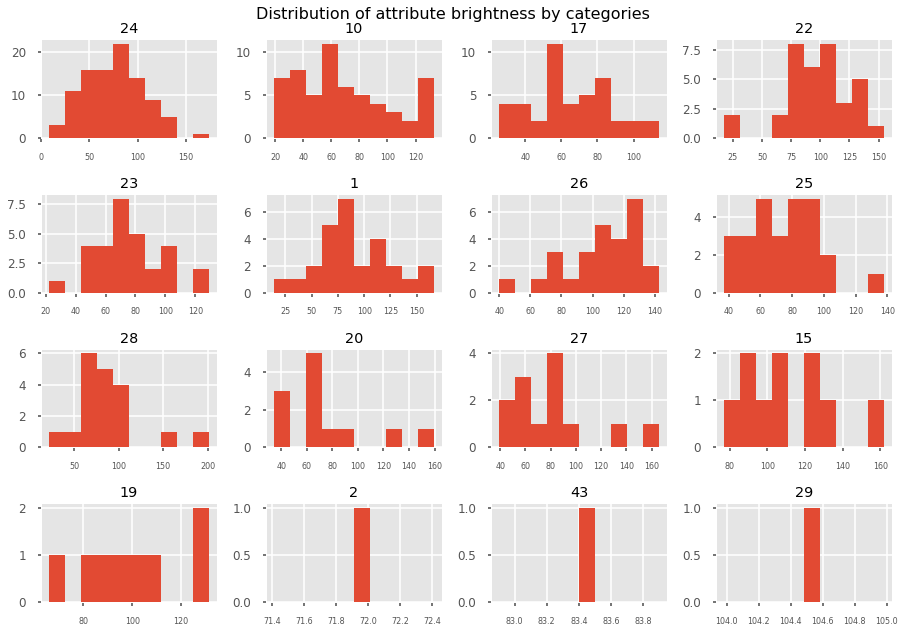

In [257]:
show_plots(df_cat, 'brightness', cats, ticks=True, hist=True)

# Notes about attributes useful for classification vs gaining new knowledge for YouTuber

The project consists of two main tasks: category prediction and crafting knowledge for YouTuber, which will allow him or her to make trending videos. Some attributes have been deleted in previous parts of this document, because most probably they wouldn't be useful. Let's discuss some attributes: do they seem to be useful for both tasks? 

There are some attributes, which video owner can't control directly:
* `views` - the Youtuber can't set the views count, people must see the video - he/she can only attempt to spread it over the Internet or ask friends for help, but still can't control it directly
* `likes`, `dislikes` and`comment_count` - same as `views` - the person can only encourage viewers to give a like

Contrary, above attributes can be helpful in predicting category of video.

The Youtuber can fully control such factors as: video `brightness`, `links` and other words used in the description, features connected with title (`title_num_words`, `title_capital`, `title_exc_count`, `title_que_count`), tags, weather to use tags popular in last month or not and time of video publication. All these attributes can also be useful for classification task.

Attributes based on representations such as `hog_vec`, `resNet_vec`, embeddings cannot be directly interpreted by human, so they has little informative value for gaining new knowledge, but can be very informative for classifier while assigning a category to the video. One exception is `obj_vec` vector, which tells us how many objects of different type are in the video thumbnails - it can be easily understood by human.

# Features

## Preeliminary work

### Fix uses_previous_tags

In [0]:
@memory.cache
def get_uses_previous_tags_corrected():
  return df.progress_apply(
      lambda x: x.uses_previous_tags 
      if x.publish_time.date() >= df.trending_date.min() 
      else np.NaN, axis=1
      )

df.uses_previous_tags = get_uses_previous_tags_corrected()

### Remove duplicates

In [0]:
df = df.drop_duplicates(subset='video_id', keep='last')
df_all = df.copy()

### category_id

In [0]:
df.loc[:, 'category_id'] = pd.Categorical(df.category_id)

### hog_vec

In [261]:
n_features, = df.hog_vec.values[3].flatten().shape
n_samples = len(df[df.category_id.notnull()])
print('Number of samples: ', n_samples)
print('Number of HOG features for sample: ', n_features)

Number of samples:  448
Number of HOG features for sample:  5940


Because of very high number of **HOG** features compared to the number of **labeled examples** it was decided to **remove them**.

In [0]:
df.drop(columns=['hog_vec'], inplace=True)

### Remove unused

In [0]:
df = df.drop(["video_id", 
              "title", 
              "thumbnail_link", 
              "description", 
              "publish_hour", 
              "publish_day",
              "trending_date_conv",
              "links",
              "tokens",
              "desc_preproc",
              "desc_clean",
              "desc_split",
              "publish_month"], axis=1)

### Convert dates to numbers

In [0]:
df.trending_date = df.trending_date.astype(int)
df.publish_time = df.publish_time.astype(int)
df.publish_date = df.publish_date.apply(lambda d: calendar.timegm(d.timetuple()))
df.trend_pub_date_diff = df.trend_pub_date_diff.apply(lambda d: d.total_seconds())

### Channel Title

In [265]:
df.channel_title.value_counts().describe()

count    3079.000000
mean        2.795063
std         6.188234
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       108.000000
Name: channel_title, dtype: float64

75% of the channels have no more than 2 trending movies. We will make no use of this attribute

In [0]:
df = df.drop(['channel_title'], axis=1)

### Tags

We will embedd tags using **GloVe** algorithm. Elmo won't be used in this case, because is context dependent, and tags are mostly single words - not sentences.  
A **mean** value of all tags for a entry will be extracted. 

> GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [0]:
df = df.drop(['tags'], axis=1) # We are interested in tags_split

In [268]:
@memory.cache
def load_glove():
  return api.load('glove-wiki-gigaword-50')
  
model = load_glove()

def get_glove(tags, model=model):
  vocab = model.wv.vocab
  if tags == np.NaN or tags == None:
    return np.NaN
  words = " ".join(tags).split()
  embeddings = np.array([model.get_vector(word) for word in words if word in vocab])
  return embeddings.mean(axis=0) if embeddings.shape[0] != 0 else np.NaN

df['tags_embed'] = df.tags_split.progress_apply(get_glove)
df = df.drop(['tags_split'], axis=1)

Titles will be embedded using **ELMO**

In [0]:
@memory.cache
def get_elmo():
    return hub.Module("https://tfhub.dev/google/elmo/3", trainable=False)

elmo = get_elmo()

@memory.cache
def elmo_vectors(sentences, version=1):    
    embeddings = elmo(sentences, signature="default", as_dict=True)["default"]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        return sess.run(embeddings)

@memory.cache
def get_embeded_data(sentences, batch_size=512, version=1):
    longest_sentence = sorted(sentences, key=lambda sentence: len(sentence.split(' ')))[-1]
    batches = np.array_split(sentences, len(sentences)//batch_size)
    batches = [np.insert(batch, 0, longest_sentence) for batch in batches]
    # embedded = [elmo_vectors(batch) for batch in batches]
    embedded = []
    out = display(progress(0, len(batches)), display_id=True)
    for i, batch in enumerate(batches):
      embedded.append(elmo_vectors(batch))
      out.update(progress(i, len(batches)))
    embedded = [batch[1:] for batch in embedded]
    return np.concatenate(embedded)
df = df.drop(["title_split"], axis=1)
df.reset_index(drop=True, inplace=True)
titles = df.title_alpha.apply(lambda x: " ".join([word.lower() for word in x]))
embeddings = get_embeded_data(titles.values)

df["title"] = df.apply(lambda x: embeddings[x.name], axis=1)
del embeddings

df = df.drop(["title_alpha"], axis=1)

In [270]:
df.head()

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_date,time_to_viral,trending_month,title_num_words,title_capital,title_exc_count,title_que_count,trend_pub_date_diff,uses_previous_tags,tags_count,desc_lines_count,desc_num_words,links_count,fb_links,tt_links,ig_links,sc_links,social_links,tf_idf_vector,publish_hour_sin,publish_hour_cos,publish_day_sin,publish_day_cos,publish_month_sin,publish_month_cos,brightness,palette,dominant_color,resNet_vec,obj_vec,tags_embed,title
0,1510876800000000000,NaN,1510299509000000000,8041928,60434,11437,7545,False,False,False,1510272000,7,11,5,0.212121,0,0,604800.0,NaN,9,0,114,7,1,1,1,0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.909384,-0.415957,-8.660254e-01,-0.5,-0.5,0.866025,NaN,"[nan, nan, nan, nan, nan, nan]",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.1131118, 0.4738288, -0.21703956, -0.3227033...","[0.1249686, -0.20961447, 0.32819885, -0.131303..."
1,1510876800000000000,NaN,1510467884000000000,1776127,35741,3214,3585,False,False,False,1510444800,5,11,7,0.285714,0,1,432000.0,NaN,36,11,40,7,1,1,1,0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.994400,-0.105686,-2.449294e-16,1.0,-0.5,0.866025,NaN,"[nan, nan, nan, nan, nan, nan]",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.018850293, 0.30199942, -0.21894681, -0.018...","[0.32952124, -0.2797677, -0.003068098, 0.03329..."
2,1510963200000000000,NaN,1510333203000000000,26448434,911883,53873,127481,False,False,False,1510272000,8,11,7,0.193548,0,0,691200.0,NaN,6,0,49,14,2,2,2,0,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.966722,-0.255830,-8.660254e-01,-0.5,-0.5,0.866025,72.862222,"[[20.0, 26.0, 34.0], [220.0, 223.0, 226.0], [1...","[21.0, 25.0, 33.0]","[2.179386854171753, 0.19718053936958313, 6.784...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.331814, 0.526688, 0.09136599, 0.073836006,...","[0.047858063, 0.052895997, -0.125952, 0.139018..."
3,1511740800000000000,NaN,1510540238000000000,98507,424,44,54,False,False,False,1510531200,14,11,13,0.133333,1,0,1209600.0,NaN,9,9,65,5,1,1,1,0,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.609122,0.793076,0.000000e+00,1.0,-0.5,0.866025,78.782963,"[[200.0, 155.0, 141.0], [26.0, 21.0, 21.0], [1...","[31.0, 28.0, 28.0]","[0.8971580266952515, 0.13900116086006165, 1.77...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.4513607, 0.6351019, -0.43831322, 0.0294237...","[0.10184562, 0.047724165, -0.12286457, -0.1352..."
4,1510617600000000000,NaN,1510537513000000000,9815,30,2,30,False,False,False,1510531200,1,11,9,0.043478,0,0,86400.0,NaN,0,4,26,0,0,0,0,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.442574,0.896732,0.000000e+00,1.0,-0.5,0.866025,NaN,"[nan, nan, nan, nan, nan, nan]",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0.33055073, 0.09328778, -0.17087011, 0.189635..."


## Feature scaling

All the features will be scaled/normalized by subtraction of the mean and division by standard deviation.

In [271]:
def normalize(column):
  std = column.std()
  mean = column.mean()
  return (column - mean)/std

to_normalize = list(df.select_dtypes(['float64', 'int64']).columns)
df[to_normalize] = df[to_normalize].apply(normalize)
df.head()

,trending_date,category_id,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,publish_date,time_to_viral,trending_month,title_num_words,title_capital,title_exc_count,title_que_count,trend_pub_date_diff,uses_previous_tags,tags_count,desc_lines_count,desc_num_words,links_count,fb_links,tt_links,ig_links,sc_links,social_links,tf_idf_vector,publish_hour_sin,publish_hour_cos,publish_day_sin,publish_day_cos,publish_month_sin,publish_month_cos,brightness,palette,dominant_color,resNet_vec,obj_vec,tags_embed,title
0,-1.397146,NaN,-0.220636,0.506416,0.016448,0.294101,0.044822,False,False,False,-0.219659,-0.122565,1.200262,-0.889773,-0.266371,-0.299138,-0.224974,-0.122565,NaN,-0.857688,-0.291386,-0.089187,-0.033333,0.803327,0.482893,0.457884,-0.181466,0.625057,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.725940,-0.577524,-1.421191,-0.706789,-1.689272,0.69217,NaN,"[nan, nan, nan, nan, nan, nan]",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.1131118, 0.4738288, -0.21703956, -0.3227033...","[0.1249686, -0.20961447, 0.32819885, -0.131303..."
1,-1.397146,NaN,-0.213040,-0.051843,-0.108164,0.005426,-0.085672,False,False,False,-0.211864,-0.130717,1.200262,-0.264016,0.061787,-0.299138,3.956726,-0.130717,NaN,1.336915,0.504470,-0.714446,-0.033333,0.803327,0.482893,0.457884,-0.181466,0.625057,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.849527,-0.114403,-0.110143,1.301783,-1.689272,0.69217,NaN,"[nan, nan, nan, nan, nan, nan]",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.018850293, 0.30199942, -0.21894681, -0.018...","[0.32952124, -0.2797677, -0.003068098, 0.03329..."
2,-1.380981,NaN,-0.219116,2.146363,4.313256,1.783850,3.997092,False,False,False,-0.219659,-0.118489,1.200262,-0.264016,-0.349189,-0.299138,-0.224974,-0.118489,NaN,-1.101533,-0.291386,-0.638401,0.885694,2.371709,1.649592,1.502015,-0.181466,2.035205,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.001361,-0.338513,-1.421191,-0.706789,-1.689272,0.69217,-0.280719,"[[20.0, 26.0, 34.0], [220.0, 223.0, 226.0], [1...","[21.0, 25.0, 33.0]","[2.179386854171753, 0.19718053936958313, 6.784...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.331814, 0.526688, 0.09136599, 0.073836006,...","[0.047858063, 0.052895997, -0.125952, 0.139018..."
3,-1.235491,NaN,-0.209776,-0.201312,-0.286390,-0.105859,-0.202030,False,False,False,-0.207966,-0.094032,1.200262,1.613255,-0.617693,2.034844,-0.224974,-0.094032,NaN,-0.857688,0.359769,-0.503210,-0.295913,0.803327,0.482893,0.457884,-0.181466,0.625057,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.289448,1.227127,-0.110143,1.301783,-1.689272,0.69217,-0.094800,"[[200.0, 155.0, 141.0], [26.0, 21.0, 21.0], [1...","[31.0, 28.0, 28.0]","[0.8971580266952515, 0.13900116086006165, 1.77...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.4513607, 0.6351019, -0.43831322, 0.0294237...","[0.10184562, 0.047724165, -0.12286457, -0.1352..."
4,-1.445643,NaN,-0.209899,-0.209214,-0.288379,-0.107333,-0.202821,False,False,False,-0.207966,-0.147022,1.200262,0.361741,-1.018365,-0.299138,-0.224974,-0.147022,NaN,-1.589222,-0.001984,-0.832739,-0.952360,-0.765056,-0.683805,-0.586247,-0.181466,-0.785090,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.047337,1.381847,-0.110143,1.301783,-1.689272,0.69217,NaN,"[nan, nan, nan, nan, nan, nan]",NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0.33055073, 0.09328778, -0.17087011, 0.189635..."


#### resNet_vec

In [0]:
def normalize(column_name, flatten=False):
  mask = df.loc[:,column_name].notnull()
  column = df.loc[mask, column_name]
  n_feat = column.to_numpy()[0].flatten().shape
  if flatten:
    df.loc[mask, column_name] = column.apply(lambda x: x.flatten())

  matrix = np.concatenate(df.loc[mask, column_name].to_numpy()).reshape(-1, *n_feat)
  mean, std = matrix.mean(axis=0), matrix.std(axis=0)
  df.loc[mask, column_name] = df.loc[mask, column_name].apply(lambda x: (x-mean)/std)

In [0]:
values = df.resNet_vec[~df.resNet_vec.isnull()].values
nrows = values.shape[0]
values = np.concatenate(values).reshape(nrows, -1)
values.shape
std = values.std(axis=0)
mean = values.mean(axis=0)
df.loc[~df.resNet_vec.isnull(), 'resNet_vec'] = df.resNet_vec[~df.resNet_vec.isnull()].apply(lambda x: (x-mean)/std)

#### tags_embed

In [0]:
normalize('tags_embed')

#### title

In [0]:
normalize('title')

#### Palette

In [0]:
df.loc[:,'palette'] = df.palette.apply(lambda x: np.NaN if np.any(np.isnan(x)) else x)
mask = df.palette.notnull()
df.loc[mask, 'palette'] = df.palette.loc[mask].apply(lambda x: np.concatenate(x))
n_features = 18
matrix = np.concatenate(df.palette[mask].values).reshape(-1, n_features) 
mean = matrix.mean(axis=0)
std = matrix.std(axis=0)
df.loc[mask, 'palette'] = df.loc[mask, 'palette'].apply(lambda x: (x-mean)/std)

#### Dominant color

In [0]:
mask = df.dominant_color.notnull()
n_features, = df.dominant_color[mask].values[0].shape
matrix = np.concatenate(df.dominant_color[mask].to_numpy()).reshape(-1, n_features)
mean = matrix.mean(axis=0)
std = matrix.std(axis=0)
df.loc[mask, 'dominant_color'] = df[mask].dominant_color.apply(lambda x: (x-mean)/std)

## Correlations

### Numeric features

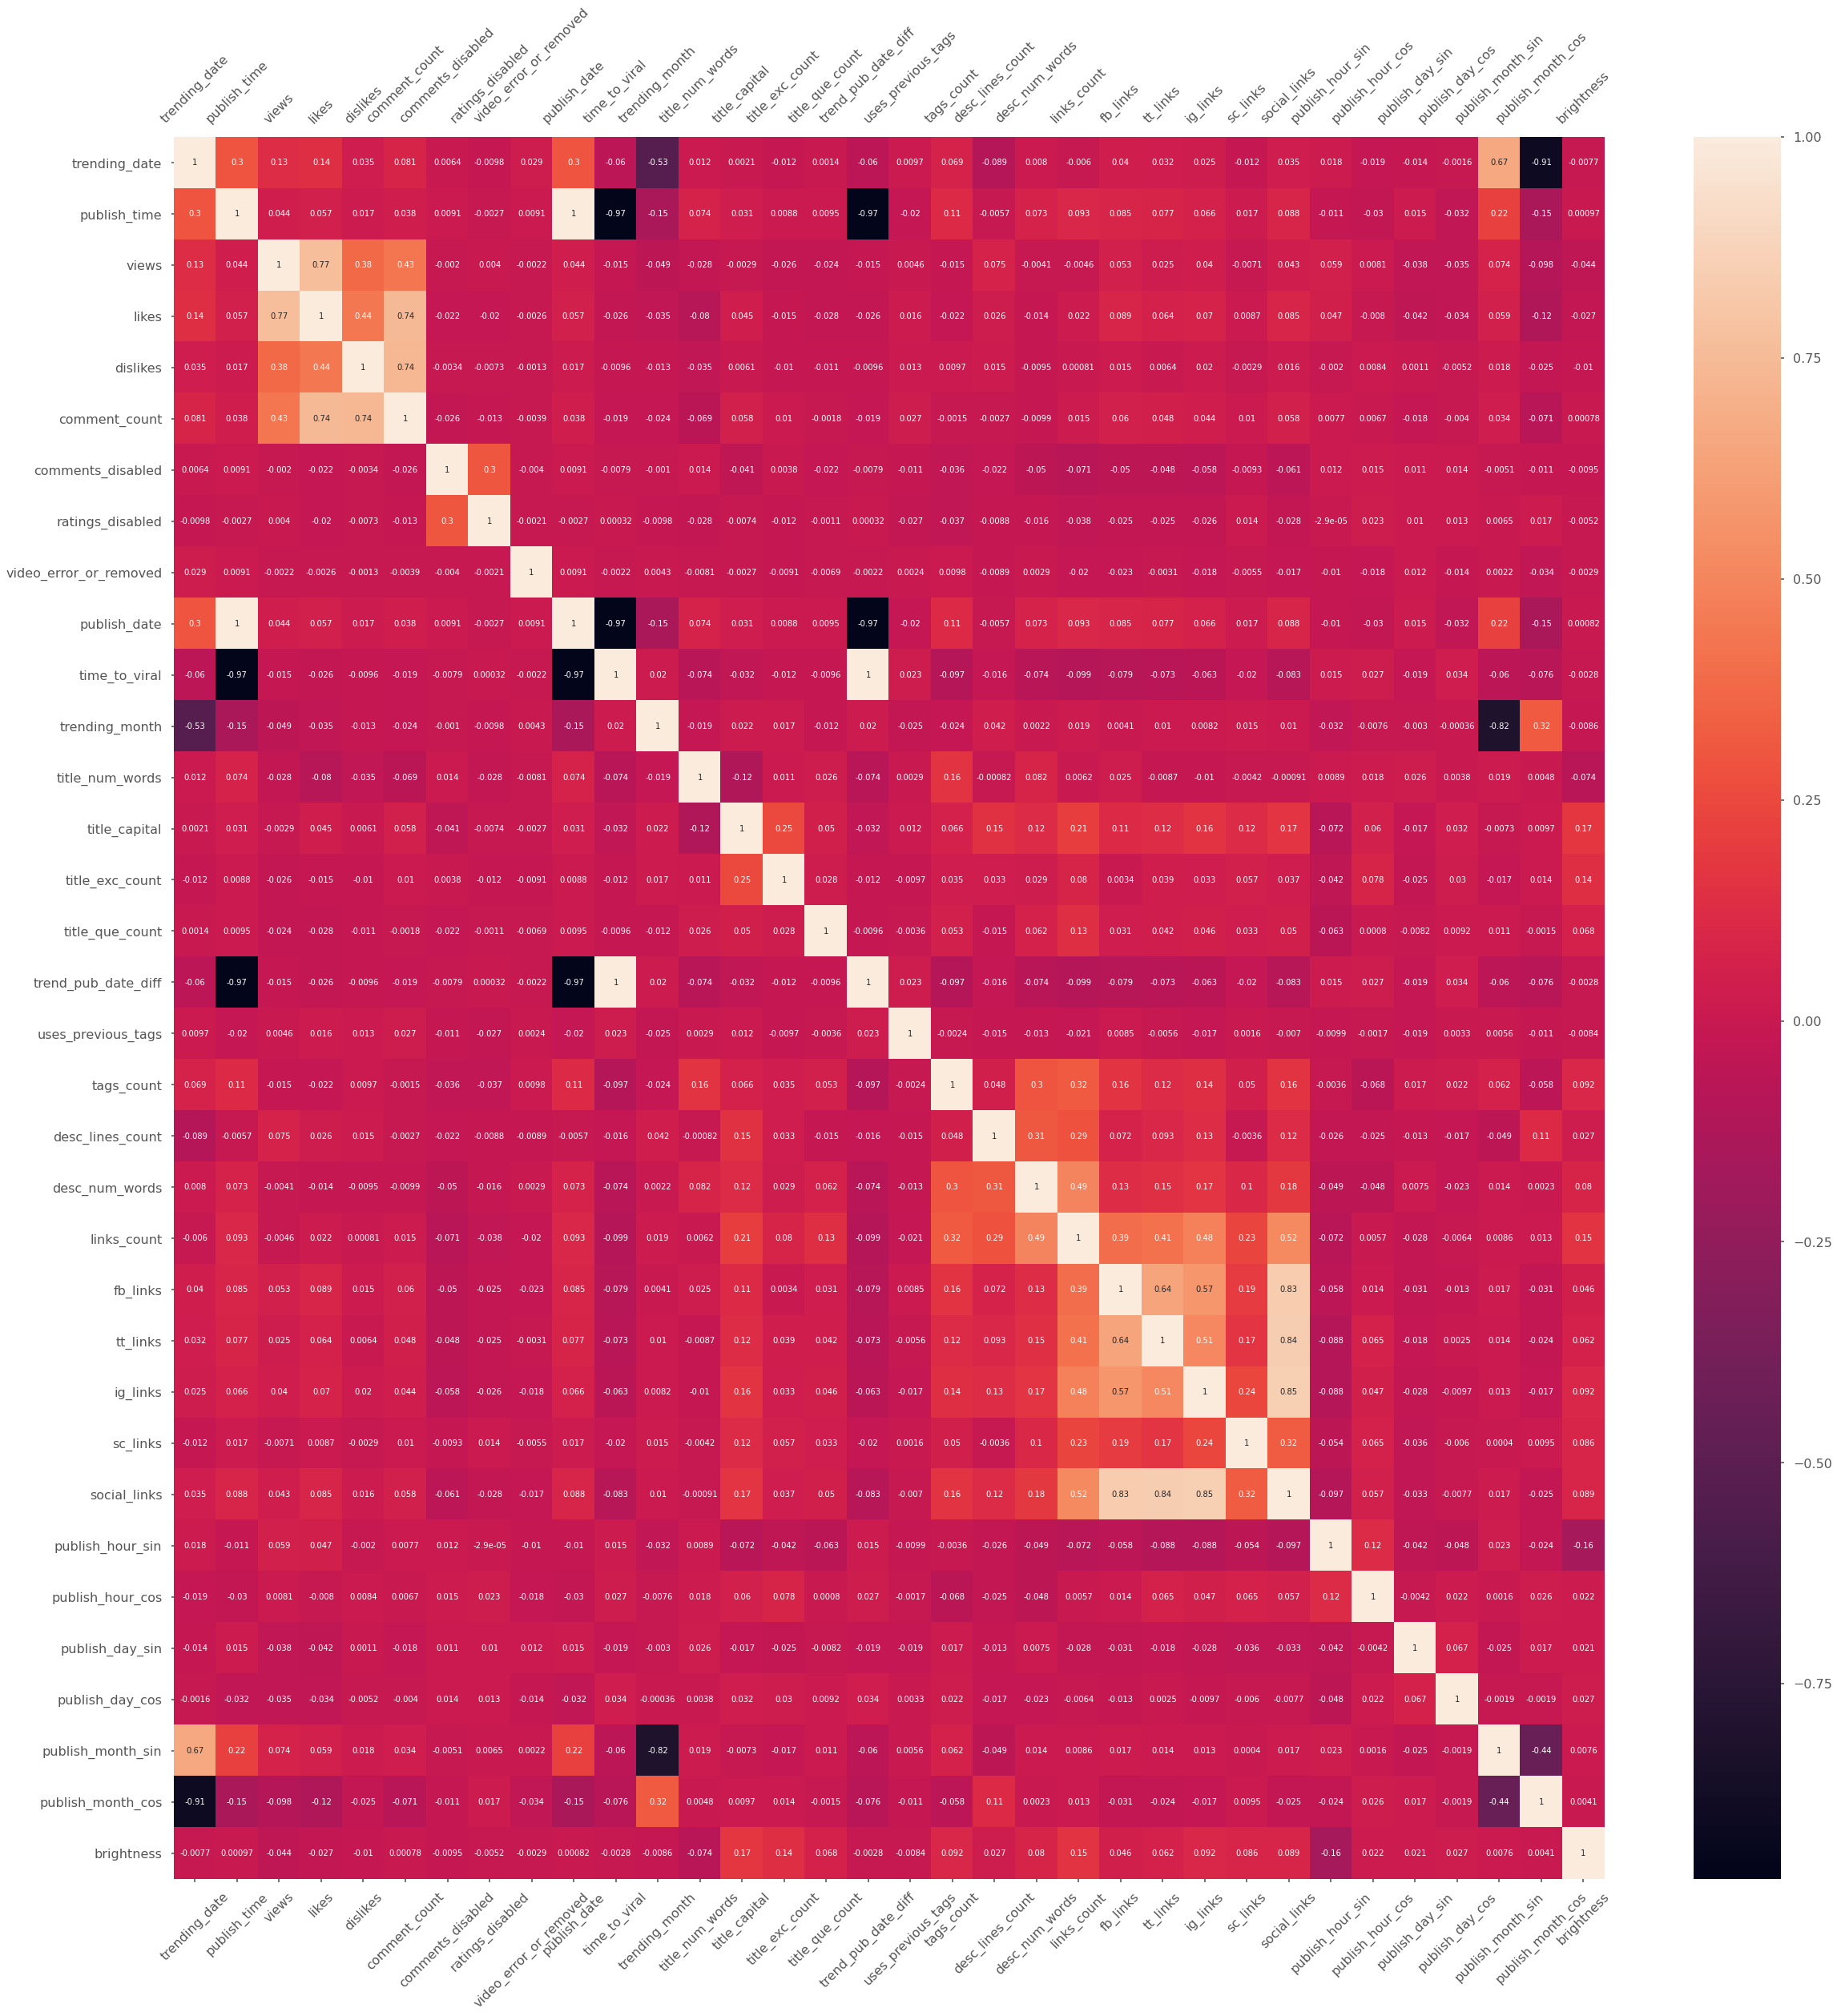

In [278]:
corrs = df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(corrs, annot=True)
plt.tick_params(axis='both', labeltop=True);
plt.xticks(rotation=45);

After analyzing the covariance matrix it was decided to remove highly correlated and redundant features (correlation higher than 0.7) and boolean features, which are represented as numbers and incorrectly recognized as numerous.

In [0]:
to_drop = ['trending_date', 'trending_month','social_links', 
           'trend_pub_date_diff', 'time_to_viral', 'publish_time',
           'comment_count', 'likes'] 
df.drop(columns=to_drop, inplace=True)
df_for_corr = df.copy().drop(columns=['comments_disabled', 'video_error_or_removed', 'ratings_disabled' ])

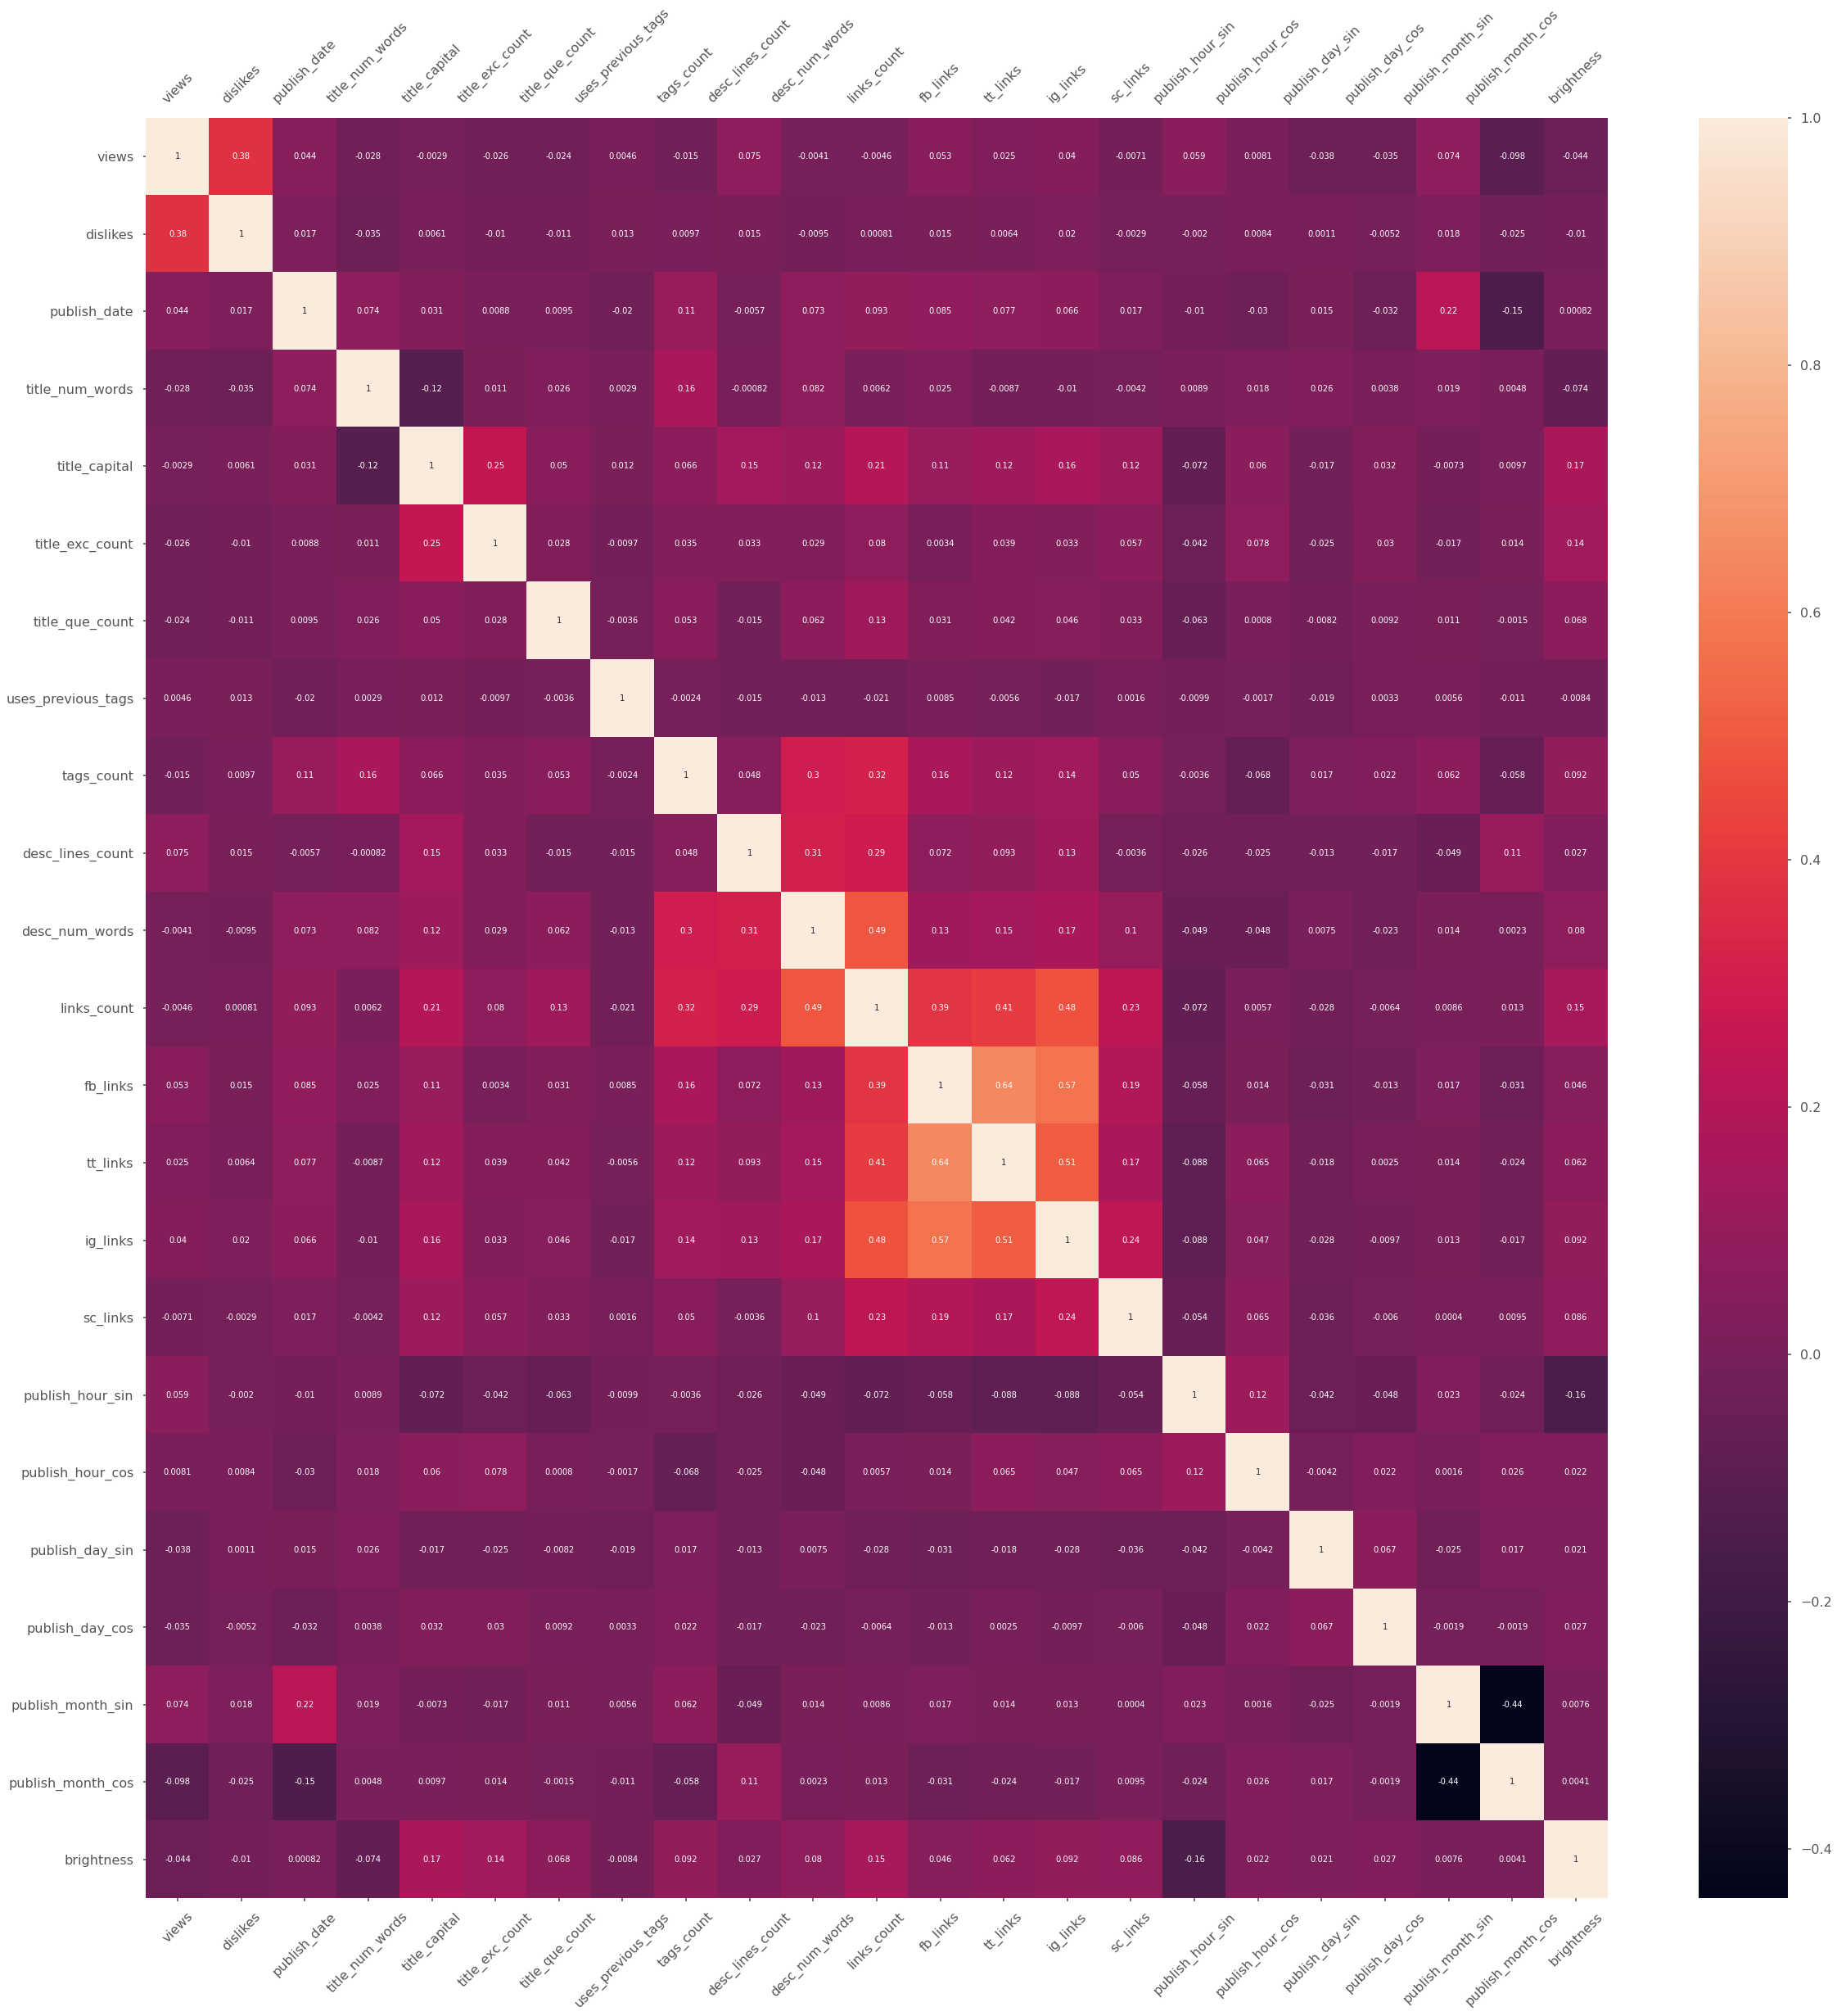

In [280]:
corrs = df_for_corr.corr()
plt.figure(figsize=(40,40))
sns.heatmap(corrs, annot=True)
plt.tick_params(axis='both', labeltop=True);
plt.xticks(rotation=45);

As we can see, after the removal we don't have the correlations anymore.

### Correlation of attributes with video category

Due to the fact that video category is a categorical feture, we cannot use Pearson correlation , because it works only for numerical features. For analyzing association between numerical and categorical variables we will use [Correlation ratio](https://en.wikipedia.org/wiki/Correlation_ratio). "Mathematically, it is defined as the weighted variance of the mean of each category divided by the variance of all samples; in human language, the Correlation Ratio answers the following question: _Given a continuous number, how well can you know to which category it belongs to?_ [...] the output is on the range of [0,1]." - by Shaked Zychlinski. The implementation was inspired by [his code](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) . Missing values will be replaced with mean.

In [0]:
def correlation_ratio(categories, measurements):
    cats = list(set(categories))
    y_avg_array = np.zeros(len(cats))
    n_array = np.zeros(len(cats))
    for i, c in enumerate(cats):
        cat_measures = measurements[np.argwhere(categories == c).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [0]:
df_cat_corr = df_all[~df_all.category_id.isnull()]
df_cat_corr = df_cat_corr.astype({'category_id': 'int32'})
cols = ['views', 'likes', 'dislikes', 'comment_count',
       'title_num_words', 'title_capital', 'title_exc_count',
       'title_que_count', 'time_to_viral', 'uses_previous_tags',
       'tags_count', 'desc_lines_count', 'desc_num_words', 'links_count', 
       'fb_links', 'tt_links', 'ig_links', 'sc_links', 'social_links', 
       'publish_hour_sin', 'publish_hour_cos', 'publish_day_sin', 'publish_day_cos', 
       'publish_month_sin', 'publish_month_cos', 'brightness']
categories_vec = np.array(list(df_cat_corr.category_id))
df_cat_corr = df_cat_corr[cols]
df_cat_corr = df_cat_corr.fillna(df_cat_corr.mean())

In [0]:
eta = []
for cat in df_cat_corr.columns:
  eta.append(correlation_ratio(categories_vec, np.array(list(df_cat_corr[cat]))))

In [284]:
for i in range(len(eta)):
  print(cols[i], ": ", eta[i])

views :  0.27390735452669907
likes :  0.2617456437744167
dislikes :  0.21048788680267513
comment_count :  0.17543019238677646
title_num_words :  0.36945592899787927
title_capital :  0.3423851985511455
title_exc_count :  0.24599994576968245
title_que_count :  0.26684672684204797
time_to_viral :  0.1260111555960664
uses_previous_tags :  0.16218748404736008
tags_count :  0.3892183427280436
desc_lines_count :  0.2168900504220826
desc_num_words :  0.2573822050495402
links_count :  0.22035494251881918
fb_links :  0.27253608919305516
tt_links :  0.21718656118859753
ig_links :  0.23162695910385456
sc_links :  0.3195113352510527
social_links :  0.24810551266353545
publish_hour_sin :  0.2734918729078736
publish_hour_cos :  0.21774977781956206
publish_day_sin :  0.15685754091039353
publish_day_cos :  0.20358233276514026
publish_month_sin :  0.18379908028505124
publish_month_cos :  0.1571902753628266
brightness :  0.38697383494608517


According to the selected measure, there are no numerical attributes strongly correlated with video category.


It may be informative to examine the correlation of objects appearing on the video thumbnail with the film category.

In [0]:
df_cat_obj = df_all[~df_all.category_id.isnull()]
df_cat_obj = df_cat_obj.astype({'category_id': 'int32'})
freqs_vecs = []
obj_corr = []
for i in range (len(df_cat_obj.iloc[0].obj_vec)):
  freqs = df_cat_obj.obj_vec.map(lambda x: x[i])
  freqs_vecs.append(freqs)
  obj_corr.append(correlation_ratio(np.array(list(df_cat_obj.category_id)), np.array(list(freqs))))

In [286]:
obj_corr

[0.2887759182922369,
 0.16991343332290545,
 0.2111965890218096,
 0.6281676484781706,
 0.11025432916596663,
 0.14154433899160968,
 0.3507741518311193,
 0.2132801947242073,
 0.1831858263618279,
 0.08291025406917366,
 0.21328019472420737,
 0.14154433899160965,
 0.0,
 0.0,
 0.27360195152476907,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.14154433899160962,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2633462177914388,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

As we can see, there are no strong correlations between objects on thumbnail and video category. Let's visualize some most popular objects:

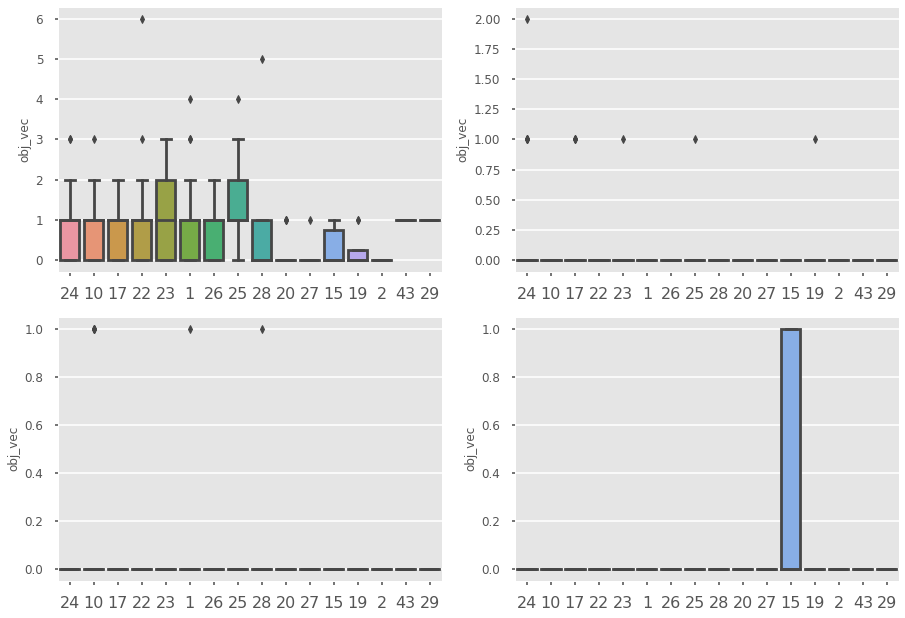

In [287]:
cats = list(df_cat_obj.category_id.value_counts().keys())
fig=plt.figure()
columns = 2
rows = 2
for i in range(4):
  fig.add_subplot(rows, columns, i+1)
  sns.boxplot(x=df_cat_obj['category_id'], y=freqs_vecs[i], order=cats);
  plt.tick_params(axis='y', labelsize=12)
  plt.xlabel('')
fig.tight_layout(pad=1.5)
plt.show()

These fuatures seem not to be very informative, but we will not delete them having in mind semi-supervised learning task - they may come in handy when coming up with data clusters.

## Convert multidimensionsional features to separate columns

In [288]:
def get_cols(vec_col_name):
  mask = df.loc[:, vec_col_name].notnull()
  col_len = len(df.loc[mask, vec_col_name].values[0])

  nan_to_nan_vec = lambda x: [np.NaN]*col_len if np.any(np.isnan(x)) else x
  df.loc[:, vec_col_name] = df.loc[:, vec_col_name].apply(nan_to_nan_vec)

  col_names = [vec_col_name + str(i) for i in range(col_len)]
  col_values = df.loc[:,vec_col_name].values.tolist()
  return pd.DataFrame(col_values, columns=col_names)

vecs = df.select_dtypes(['object']).columns.values.tolist()
df_tab = df.copy()

for vec in vecs:
  cols = get_cols(vec)
  df_tab = df_tab.join(cols)
  print(vec, ' ', cols.shape)
  
df_tab.drop(vecs, axis=1, inplace=True)

tf_idf_vector   (8606, 1000)
palette   (8606, 18)
dominant_color   (8606, 3)
resNet_vec   (8606, 512)
obj_vec   (8606, 37)
tags_embed   (8606, 50)
title   (8606, 1024)


## Fill missing values with column's means

In [289]:
num_cols = df_tab.select_dtypes(['float64', 'int64']).columns
df_num = df_tab.loc[:,num_cols]
df_tab.loc[:,num_cols] = df_num.fillna(df_num.mean())
df_tab.isnull()

,category_id,views,dislikes,comments_disabled,ratings_disabled,video_error_or_removed,publish_date,title_num_words,title_capital,title_exc_count,title_que_count,uses_previous_tags,tags_count,desc_lines_count,desc_num_words,links_count,fb_links,tt_links,ig_links,sc_links,publish_hour_sin,publish_hour_cos,publish_day_sin,publish_day_cos,publish_month_sin,publish_month_cos,brightness,tf_idf_vector0,tf_idf_vector1,tf_idf_vector2,tf_idf_vector3,tf_idf_vector4,tf_idf_vector5,tf_idf_vector6,tf_idf_vector7,tf_idf_vector8,tf_idf_vector9,tf_idf_vector10,tf_idf_vector11,tf_idf_vector12,...,title984,title985,title986,title987,title988,title989,title990,title991,title992,title993,title994,title995,title996,title997,title998,title999,title1000,title1001,title1002,title1003,title1004,title1005,title1006,title1007,title1008,title1009,title1010,title1011,title1012,title1013,title1014,title1015,title1016,title1017,title1018,title1019,title1020,title1021,title1022,title1023
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8601,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False

## Apply **PCA** in order to remove redundant features

**PCA** will be applied to all numerical variables

In [0]:
if not(torch.cuda.is_available()):
  raise RuntimeError('No GPU acceleration')

device = torch.device("cuda")

X = df_tab.select_dtypes(['float64', 'int64']).to_numpy()
X = torch.from_numpy(X).to(device).T
n, m = X.shape 

sigma = 1/m * (X @ X.T) # Covariance matrix

with torch.no_grad():
  U, S, V = torch.svd(sigma)
  
csum = torch.cumsum(S, dim=0)
var = (csum/sum(S)) * 100
var = var.cpu().numpy()

Results

In [0]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

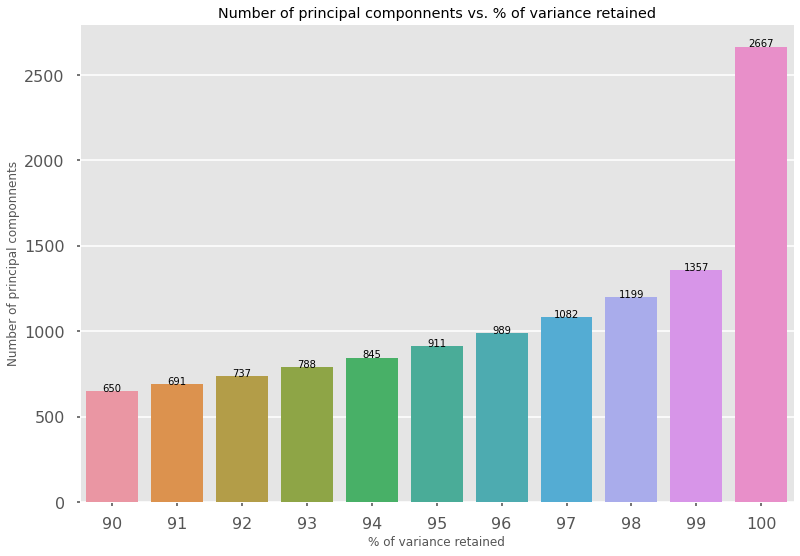

In [292]:
ax = sns.barplot(list(range(90,100)) + [100], [np.argmax(var >= k) for k in range(90, 100)] + [len(var)], )
show_values_on_bars(ax)
ax.set_xlabel("% of variance retained")
ax.set_ylabel("Number of principal componnents")
ax.set_title("Number of principal componnents vs. % of variance retained");

In [0]:
k = np.argmax(var >= 95)
U_reduce = U[:,:k]
matrix_reduce = U_reduce.T @ X
matrix_reduce = matrix_reduce.cpu().numpy().T

In [294]:
print('U_reduce:', U_reduce.size())
print('X:', X.shape)
print('matrix_reduce:', matrix_reduce.shape)

U_reduce: torch.Size([2667, 911])
X: torch.Size([2667, 8606])
matrix_reduce: (8606, 911)


1457 principal components will be retained in order to maintain 95 % of variation

In [0]:
to_drop = df_tab.select_dtypes(['float64', 'int64']).columns
df_tab.drop(columns=to_drop, inplace=True)
new_numerical = pd.DataFrame(matrix_reduce)
df_tab = df_tab.join(new_numerical)

## Boolean variables

In [296]:
bool_cols = df.select_dtypes(['boolean']).columns.values.tolist()
df.loc[:,bool_cols + ['category_id']].groupby('category_id').var()

,comments_disabled,ratings_disabled,video_error_or_removed
category_id,,,
1.0,0.034483,0.000000,0.0
2.0,0.000000,0.000000,0.0
10.0,0.000000,0.000000,0.0
15.0,0.000000,0.000000,0.0
17.0,0.022222,0.000000,0.0
19.0,0.000000,0.000000,0.0
20.0,0.000000,0.000000,0.0
22.0,0.025000,0.025000,0.0
23.0,0.027027,0.000000,0.0


**video_error_or_removed** column presents no variation amongst the classes so it will be dropped.

In [0]:
df.drop(columns=['video_error_or_removed'], inplace=True)

Missing values of the remaining columns will be filled with **mode**.

In [0]:
bool_cols = df.select_dtypes(['boolean']).columns.values.tolist()
df_bool = df.loc[:,bool_cols]
df.loc[:,bool_cols] = df_bool.fillna(df_bool.mode())

In [0]:
df = df_tab

> Estimate mutual information for a discrete target variable.  
> Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.  
> The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances (...)

In [0]:
df_cat = df.loc[df.category_id.notnull()]
X = df_cat.loc[:, df_cat.columns != 'category_id'].to_numpy()
y = df_cat.loc[:, 'category_id'].to_numpy()

In [0]:
result = mutual_info_classif(X, y)

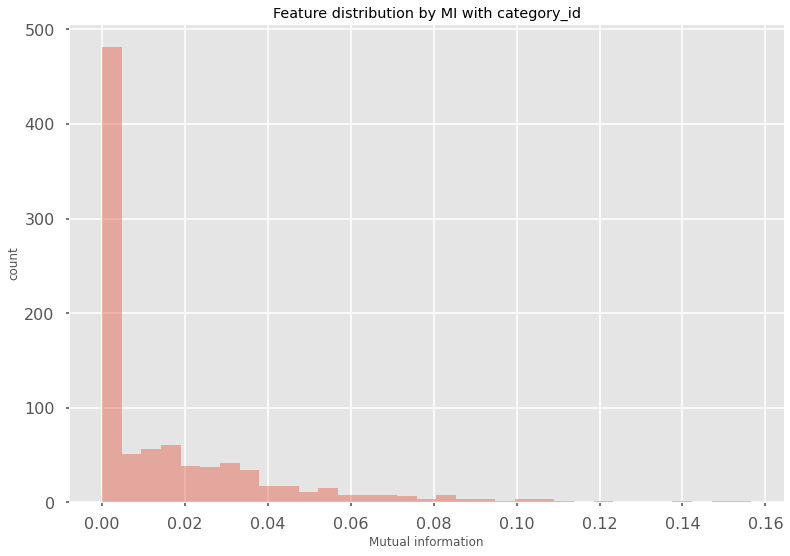

In [302]:
ax = sns.distplot(result, kde=False)
ax.set_title('Feature distribution by MI with category_id');
ax.set_xlabel('Mutual information')
ax.set_ylabel('count');

In [0]:
independent = sum(result == 0)/len(result) * 100

In [304]:
print('Independent variables: ', independent, '%')

Independent variables:  48.35886214442014 %


High percentage of variables came out to be independent with the _category\_id_. They were left however, having on mind the **SSL** task in which they may come valuable in some subtasks such as **clustering**.